## Classification - MINST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

Features are pixels so 784 pixels means images of 28x28 pixels. Let's plot one.

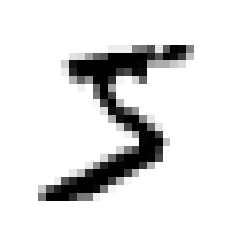

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

Is It the same as its label?

In [4]:
y[0]

'5'

String to numeric.

In [5]:
y = y.astype("uint8")

Create test set before doing anything else. The dataset is already splited. First 60,000 images are for the training set and the 10,000 images left are for testing.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifier

Which images are `5`s and which are not?.

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's pick a SGDClassifier as our binary classifier.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

#### Using Cross-Validation

If we want more control over the process:

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Setting a random_state has no effect since shuffle is False.
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


Alternatively, we can use the already implemented function `cross_val_score`.

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

High scores, but to early to party. Let's implement a custom classifier to just classify all the images as "not-5"  class.

In [12]:
import numpy as np
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Let's check its accuracy.

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Similar accuracy. It is too simple metric. If you say that all images are from "not-5" class you'll be right 90% of the time as only 10% of images are trully `5`s. Better if we use other metrics.

#### Confusion Matrix

Matrix where rows are actual class and columns are the predicted. To get this matrix, first we predict our classes with `cross_val_predict` from Sci-Kit Learn's library and then we get the matrix with `confusion_matrix` from `sklearn.metrics` comparing predictions to the training actual classes.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

This is:

* There are 53892 images of the "non-5" class in the training set and were correctly classified by the model ( _true negatives_ ), while the 687 images in the training set were wrongly classified by the model ( _false positives_ ).
* There are 1891 images were wrongly classified as "non-5" ( _false negatives_ ), while the remaining 3,530 where correctly classified as 5 ( _true positives_ )

In a perfect confusion matrix there wouldn't be any false positive neither any false negative.

In [15]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

When you prefer a more concise metric there are those two. Precision is focused in the accuracy of postive predictions. I.e. It makes reference to the percentage of your results which are relevant.

$$precision=\frac{True\ Positives}{Actual\ Results}=\frac{TP}{TP+FP}$$

On the other hand, recall (or sensitivity, or _True Positive Rate_) refers to the percentage of total relevant results correctly classified by your algorithm.

$$recall=\frac{True\ Positives}{Predicted\ Results}=\frac{TP}{TP+FN}$$

[Check out this reference to see _the suspicious lotery_ metaphore](https://towardsdatascience.com/precision-vs-recall-386cf9f89488).

There is a simpler metric which is called the _F1 score_ , which can be defined as the harmonic mean between _precision_ and _recall_.

$$F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2·\frac{precision·recall}{precision + recall}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1$ score favours models which have a similar precision and recall. In some (or most) of the circunstances you do care more for precision and in others for recall.

E.g. In Pagantis, where they classify customers as good payers or debtors, most of all, they do not want to give loans to potential debtors, so they don't want to have false positives (they do not care that much about those few good clients which do not get a loan as long as their loses due to are debtors are low). Therefore, their interests lie around a high precision. On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has a 99% recall (Sure, the security guards will have a few false alerts, but they will caught almost all shoplifters).

### Precision/Recall Trade-off

To understand this trade-off, let's look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a _decision function_. If that score is greater than a threshold, it assings the instance to the positive class; otherwise, it assings to the negative class.

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Scikit-Learn does not let you set the thershold directly, but it does give you access to the decision scores that it uses to make predictions.

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

The `SGDClassifier` uses a threshold of `0`, so the following code will return the same as the `predict()` method.

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

If we raise the threshold, the recall decreases. If we use a threshold of `8,000` we will see how the classifier miss the prediction.

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How to select the threshold? First get the scores for all instances in the training set.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

With the scores, you use `precision_recall_curve()` function to compute precision and recall for all possible thresholds.

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value.

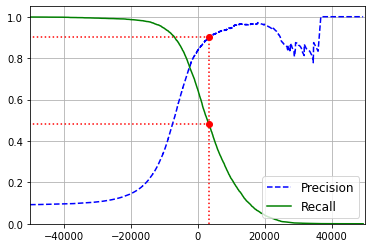

In [24]:
def plot_precision_recall_vs_threshold(
precisions, recalls, thresholds, selected_th
):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="lower right", fontsize=12)
    plt.grid()
    plt.ylim([0, 1.05])
    
    # highlight threshold
    precision_threshold_pairs = list(zip(thresholds, precisions))
    recall_threshold_pairs = list(zip(thresholds, recalls))
    
    # could be done better
    xy1 = [t for t in precision_threshold_pairs if t[1] >= selected_th][0]
    xy2 = [t for t in recall_threshold_pairs if t[0] == xy1[0]][0]
    
    plt.vlines(xy1[0], 0, xy1[1], "red", "dotted")
    plt.hlines(xy1[1], -60000, xy1[0], "red", "dotted")
    plt.hlines(xy2[1], -60000, xy2[0], "red", "dotted")
    plt.plot(xy1[0], xy1[1], marker='o', color='r', ls='')
    plt.plot(xy2[0], xy2[1], marker='o', color='r', ls='')


selected_th = .9
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, selected_th)
plt.xlim([-50000, 50000])
plt.show()

The precision may go down as you increase the threshold

Another way to see this is ploting precision over recall directly.

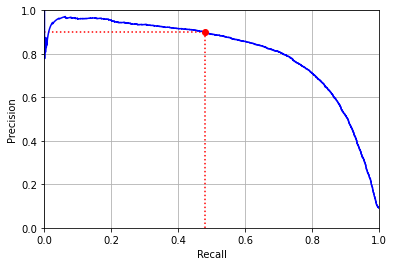

In [30]:
plt.figure()
plt.plot(recalls, precisions, "b-")

precision_threshold_pairs = list(zip(thresholds, precisions))
recall_threshold_pairs = list(zip(thresholds, recalls))
xy1 = [t for t in precision_threshold_pairs if t[1] >= selected_th][0]
xy2 = [t for t in recall_threshold_pairs if t[0] == xy1[0]][0]

plt.hlines(xy1[1], 0, xy2[1], "red", "dotted")
plt.vlines(xy2[1], 0, xy1[1], "red", "dotted")
plt.plot(xy2[1], xy1[1], marker='o', color='r', ls='')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

plt.show()

Precision really starts to fall at 70% recall. A good choice could be a precision before that point, however, it will allways depend on the project.